# Particle Tracking with Steaming (based on .HDF5 file)

This notebook provides an example for;
    1. tracking particle position from an image sequence
    2. linking positions to construct particle's trajectory
    3. filtering spurious trajectories
    4. drift calculation and drift subtraction
    5. msd calculation



## Image sequence

In [31]:
import pims
import trackpy as tp
import matplotlib.pyplot as plt
import progressbar

In [2]:
frames = pims.ImageSequence("video_test_stream/*.tif")

Frame([[ 9,  9,  9, ...,  7,  9,  9],
       [ 9,  9,  8, ...,  8,  8,  8],
       [ 9,  9,  7, ...,  7,  8,  7],
       ..., 
       [ 9,  9, 10, ...,  9,  9,  7],
       [10, 10,  9, ...,  8,  8,  9],
       [ 9, 10,  9, ...,  7,  8,  9]], dtype=uint8)
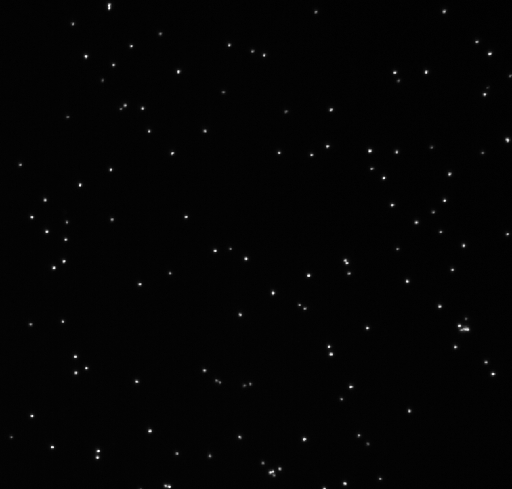

In [47]:
frames[671]

## Locate features

In [8]:
maxact = 8 # number of activity in the exp
size = 11 # estimate particle size in pixel (diameter)
mm = 300 # minmass
maxdis = 6 # max displacement
mem = 10 # allow particle to disappear for some period
#Nframes = 2000 # no. of frames per one activity
threshold = 1

In [9]:
f = tp.locate(frames[0], size, minmass=mm, smoothing_size = 7, threshold = threshold,percentile=0, separation = 3, characterize = True) # 'look for bright' position, number indicates size of particle (in pixel)

In [12]:
f.head()

,x,y,mass,size,ecc,signal,raw_mass,ep,frame
0,502.250177,4.277032,1024.013784,2.185561,0.123621,63.684249,2248.0,0.011639,0
1,397.193759,11.299347,1994.474903,2.118325,0.030823,117.960598,3798.0,0.005798,0
2,645.960733,26.756254,2488.027836,2.179082,0.094892,141.118507,4586.0,0.004619,0
3,169.819874,34.223186,4588.160698,2.764551,0.299869,158.486939,8535.0,0.002288,0
4,106.413293,34.578852,1197.698100,2.196262,0.119867,70.197411,2553.0,0.009713,0


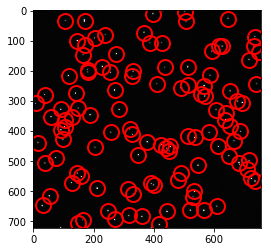

In [10]:
plt.figure()  # make a new fi
tp.annotate(f, frames[0]); 

In [27]:
!rm -f test_position.h5

In [39]:
pro = progressbar.ProgressBar(len(frames))
with tp.PandasHDFStoreSingleNode("test_position.h5") as p:  # This opens an HDF5 file. Data will be stored and retrieved by frame number.
    for i ,frame in enumerate(frames):
        features = tp.locate(frame, size, minmass= 300, smoothing_size = 7, threshold = 1, separation = 3)  # Find the features in a given frame.
        features.drop(features.columns[[5,6,7]], axis = 1, inplace = True) # drop [signal, raw_mass, ep]
        p.put(features)
        pro.animate(i)

# Linking positions

In [41]:
with tp.PandasHDFStoreSingleNode("test_position.h5") as p:
    with tp.PandasHDFStoreSingleNode("test_traj.h5") as traj:
        for i, linked in enumerate(tp.link_df_iter(p, search_range = 6, memory=10)):
            traj.put(linked)

Frame 800: 115 trajectories present


In [42]:
with tp.PandasHDFStoreSingleNode("test_traj.h5") as traj:
    traj_frame = traj.get(0)

In [43]:
traj_frame.head()

,x,y,mass,size,ecc,frame,particle
0,502.250177,4.277032,1024.013784,2.185561,0.123621,0,0.0
1,397.193759,11.299347,1994.474903,2.118325,0.030823,0,1.0
2,645.960733,26.756254,2488.027836,2.179082,0.094892,0,2.0
3,169.819874,34.223186,4588.160698,2.764551,0.299869,0,3.0
4,106.413293,34.578852,1197.698100,2.196262,0.119867,0,4.0


In [44]:
import plots_trackpy

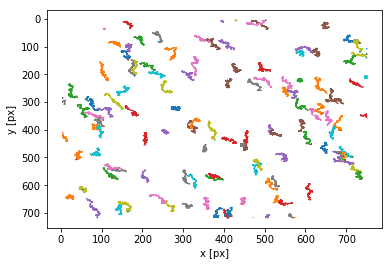

In [45]:
plots_trackpy.plot_traj_stream("test_traj.h5")

# Filter spurious trajectories